# **Import Relevant Libraries**

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# **Creating Train and Test Dataframes**

In [4]:
df = pd.read_csv('dict.csv', sep=",",header=None)
df['image']=df[0]
df['label']=df[1]

In [5]:
df.head()

,0,1,image,label
0,new_data0.jpeg,normal,new_data0.jpeg,normal
1,new_data1.jpeg,normal,new_data1.jpeg,normal
2,new_data2.jpeg,normal,new_data2.jpeg,normal
3,new_data3.jpeg,normal,new_data3.jpeg,normal
4,new_data4.jpeg,normal,new_data4.jpeg,normal


In [6]:
data=df[['image','label']]

In [7]:
data.head()

,image,label
0,new_data0.jpeg,normal
1,new_data1.jpeg,normal
2,new_data2.jpeg,normal
3,new_data3.jpeg,normal
4,new_data4.jpeg,normal


In [8]:
data.shape


(5856, 2)

In [9]:
data['label'].value_counts()

PNEUMONIA    4273
normal       1583
Name: label, dtype: int64

<AxesSubplot:>

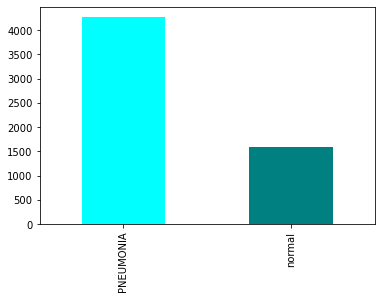

In [10]:
data['label'].value_counts().plot(kind = 'bar',color=['cyan', 'teal'])

In [11]:
file_count = 1583
samples = []
for category in data['label'].unique():    
    category_slice = data.query("label == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
data = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print ( data['label'].value_counts())
print (len(data))

normal       1583
PNEUMONIA    1583
Name: label, dtype: int64
3166


In [12]:
a=data.copy()
a=pd.get_dummies(data['label'])
df1=pd.concat([data, a], axis=1)
df1.head()

,image,label,PNEUMONIA,normal
0,new_data385.jpeg,normal,0,1
1,new_data4745.jpeg,PNEUMONIA,1,0
2,new_data343.jpeg,normal,0,1
3,new_data3951.jpeg,PNEUMONIA,1,0
4,new_data3738.jpeg,PNEUMONIA,1,0


In [13]:
df1.drop(columns='label', inplace=True)
df1.shape

(3166, 3)

C:\Users\asus\AppData\Local\Temp/ipykernel_41904/60640882.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=df1.mean()


<AxesSubplot:ylabel='None'>

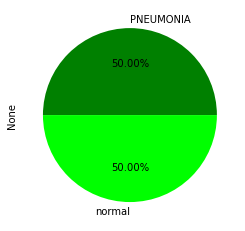

In [18]:
pcts=df1.mean()

pcts.plot(kind = 'pie',autopct='%1.2f%%',colors=['green','lime'])

# split

In [193]:
path='path/'
data_path=df1.image.apply(lambda x: path +x).values
data_path

array(['path/new_data385.jpeg', 'path/new_data4745.jpeg',
       'path/new_data343.jpeg', ..., 'path/new_data1076.jpeg',
       'path/new_data3.jpeg', 'path/new_data412.jpeg'], dtype=object)

In [194]:
data_labels=df1.loc[:, ['normal','PNEUMONIA']].values

In [195]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.05, random_state=42)

In [196]:
train_paths, val_paths, train_labels, val_labels =train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)

In [197]:
train_paths

array(['path/new_data975.jpeg', 'path/new_data177.jpeg',
       'path/new_data3030.jpeg', ..., 'path/new_data4984.jpeg',
       'path/new_data4775.jpeg', 'path/new_data5026.jpeg'], dtype=object)

# **Image Data Generators**

In [198]:

IMG_SIZE=224
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [206]:
BATCH_SIZE =16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

train_dataset_1 = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(16)
    .prefetch(AUTO)
)


valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_paths, val_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(16)
    .cache()
    .prefetch(AUTO)
)


test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths, test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

# **Create Model**

In [201]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224,224,3))

In [207]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [208]:
lr=0.0001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

# **Model Training**

In [209]:

history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // 16,
    epochs=30,
    validation_data=valid_dataset
    )

Epoch 1/30
197/197 [==============================] - 1113s 6s/step - loss: 0.2397 - accuracy: 0.9099 - val_loss: 0.2376 - val_accuracy: 0.8920
Epoch 2/30
197/197 [==============================] - 1153s 6s/step - loss: 0.1776 - accuracy: 0.9397 - val_loss: 0.2742 - val_accuracy: 0.8804
Epoch 3/30
197/197 [==============================] - 1144s 6s/step - loss: 0.1092 - accuracy: 0.9622 - val_loss: 0.1801 - val_accuracy: 0.9302
Epoch 4/30
197/197 [==============================] - 1035s 5s/step - loss: 0.1196 - accuracy: 0.9569 - val_loss: 0.1652 - val_accuracy: 0.9402
Epoch 5/30
197/197 [==============================] - 1065s 5s/step - loss: 0.0935 - accuracy: 0.9641 - val_loss: 0.1331 - val_accuracy: 0.9502
Epoch 6/30
197/197 [==============================] - 1058s 5s/step - loss: 0.0705 - accuracy: 0.9765 - val_loss: 0.1567 - val_accuracy: 0.9502
Epoch 7/30
197/197 [==============================] - 1056s 5s/step - loss: 0.0805 - accuracy: 0.9721 - val_loss: 0.0958 - val_accuracy:

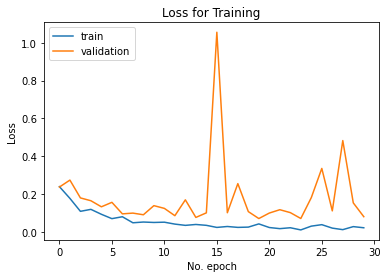

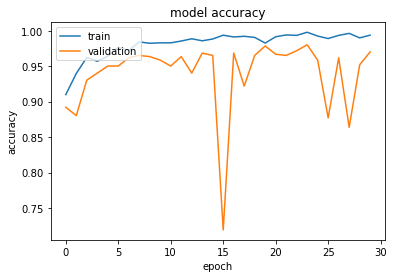

In [210]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [161]:
results

[0.1370844542980194, 0.9496855139732361]

# **Predictions on Test Set**

In [211]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 10s 1s/step - loss: 0.0635 - accuracy: 0.9748
test loss, test acc: [0.06350849568843842, 0.9748427867889404]
